### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [23]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler


VERBOSE = 1
CV = 4 #[(slice(None), slice(None))]
TESTING = True

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [24]:
ITER = 2

hyperparameterspace = {
    'regressor__regressor__epochs': ["interval-int", 1, 2],
    'regressor__regressor__batch_size': ["interval-int", 10, 200],
    'regressor__regressor__model__optimizer__learning_rate': ["interval-log", 0.0000001, 0.1]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [25]:
ids = [233211, 359952, 359931, 359949, 359938]
# [359940, 317614, 359934, 359946, 359932, 233214, 359943]


def relu_advanced(x):
    return K.relu(x)


ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=42)

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(learning_rate=0.0001, input_dim=10):
        # create model
        model = Sequential()
        model.add(Dense(30, input_shape=(input_dim,), activation=ACTIVATION_FUNCTION,
                  kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        model.add(Dense(30, activation=ACTIVATION_FUNCTION,
                  kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    def evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers):
        # Function to create model, required for KerasClassifier
        def create_model(learning_rate=0.0001, input_dim=10):
            # create model
            model = Sequential()
            model.add(Dense(30, input_shape=(input_dim,), activation=ACTIVATION_FUNCTION,
                      kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            model.add(Dense(30, activation=ACTIVATION_FUNCTION,
                      kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
            model.add(Dense(1, activation=None))

            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

            model.compile(loss='mean_squared_error', optimizer=optimizer)
            return model

        kfold = KFold(n_splits=CV)

        split = (kfold.split(dataset.get_X(), dataset.get_Y()))

        values = []

        # partial one hot encoding
        onehotencoder = ColumnTransformer(
            transformers=[
                ("categorical", OneHotEncoder(sparse_output=False),
                 dataset.get_categorical_indicator())
            ], remainder='passthrough'
        )

        # final regressor
        regressor = TransformedTargetRegressor(regressor=KerasRegressor(model=create_model, input_dim=dataset.get_input_dim(), verbose=0),
                                               transformer=StandardScaler())

        pipeline = Pipeline([
            ('ohencoder', onehotencoder),
            ('standardizer', StandardScaler(with_mean=False)),
            ('regressor', regressor)
        ])

        for i, (train_index, test_index) in enumerate(split):
            X_train = dataset.get_X()[train_index]
            Y_train = dataset.get_Y()[train_index]

            X_val = dataset.get_X()[test_index]
            Y_val = dataset.get_Y()[test_index]

            model = KerasRegressor(model=create_model, verbose=0)

            pipeline.fit(X_train, Y_train, regressor__epochs=epochs,
                         regressor__batch_size=batch_size)

            Y_predicted = pipeline.predict(X_val)
            error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
            values.append(error)

            K.clear_session()
            del model

        result = sum(values)/len(values)
        return result

    def blackboxfunction(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]
        loss = 'mean_squared_error'

        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = 40  # int(params[3])

        number_of_layers = 1  # int(params[4])

        return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(
                len(hyperparameterspace.keys()))

        def eval(self, x):
            # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            # hyperparameterspace_special["loss"][index]
            loss = 'mean_squared_error'

            epochs = int(HPO.from_standard(
                hyperparameterspace_special["regressor__regressor__epochs"][0], hyperparameterspace_special["regressor__regressor__epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(
                hyperparameterspace_special["regressor__regressor__batch_size"][0], hyperparameterspace_special["regressor__regressor__batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["regressor__regressor__model__optimizer__learning_rate"][
                                                        0], hyperparameterspace_special["regressor__regressor__model__optimizer__learning_rate"][1], x[2])

            # int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))
            neurons_per_layer = 40

            # int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))
            number_of_layers = 1

            return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1) * 2
        print("\n################################################## Current Budget:",
              BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")

        optimization = HPO.GridSearchOptimization(
            dataset, create_model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)

        GRID_RESULT.append(-result.best_score_)
        GRID_COST.append(cost)

        K.clear_session()

        ########################### RANDOM SEARCH #######################
        print("Performing random search")

        optimization = HPO.RandomSearchOptimization(
            dataset, create_model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        RANDOM_RESULT.append(-result.best_score_)
        RANDOM_COST.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT #####################
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)

        result = optimization.fit()

        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = m

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        BAYESIAN_RESULT.append(best_score)
        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(
            dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.2, optimizer="rprop")

        result = optimization.fit()

        SPARSE_RESULT.append(result[0][1])
        SPARSE_RESULT_OPTIMIZED.append(result[0][3])

        SPARSE_COST.append(result[1])
        SPARSE_COST_OPTIMIZED.append(result[1])

        K.clear_session()

        print(GRID_RESULT)
        print(RANDOM_RESULT)
        print(BAYESIAN_RESULT)
        print(SPARSE_RESULT)
        print(SPARSE_RESULT_OPTIMIZED)


######################################################################################################################################################
Current Dataset: 1 of 3 with id: 233211

################################################## Current Budget: 8 ##################################################
Performing grid search
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params found by grid search:
{'regressor__regressor__batch_size': 57, 'regressor__regressor__epochs': 15, 'regressor__regressor__model__optimizer__learning_rate': 0.10000000000000006}
Performing random search
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params found by random search:
{'regressor__regressor__batch_size': 10, 'regressor__regressor__epochs': 11, 'regressor__regressor__model__optimizer__learning_rate': 0.002197492222401901}
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 175.81855255397386 seconds
With Hyperparameters: 
regressor__regressor__epochs: 1.0
regressor__regressor__batch_size: 54.0
regressor__regressor__model__optimizer__learning_rate: 8.063142592498863e-06
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 167921ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 10.5
regressor__regressor__batch_size: 57.5
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
7068.468688964844
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 10.5
regressor__regressor__batch_size: 200.0
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
49648.26208496094
Resulting loss (Optimal point evaluated):
38884.9921875
[2718.58239

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 2881.541804473003 seconds
With Hyperparameters: 
regressor__regressor__epochs: 1.0
regressor__regressor__batch_size: 170.0
regressor__regressor__model__optimizer__learning_rate: 3.791238121945566e-07
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 7967738ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 17.03125
regressor__regressor__batch_size: 15.9375
regressor__regressor__model__optimizer__learning_rate: 3.162277660168379e-06
Resulting loss:
923.2805023193374
Optimizing (Rprop)...
Done in 1ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 17.03125
regressor__regressor__batch_size: 15.9375
regressor__regressor__model__optimizer__learning_rate: 3.162277660168379e-06
Resulting loss (Optimal value from optimization):
923.2805023193374
Resulting loss (Optimal point evaluated):
1102.015060

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 112.94673004097422 seconds
With Hyperparameters: 
regressor__regressor__epochs: 18.37121964783244
regressor__regressor__batch_size: 173.7465554117485
regressor__regressor__model__optimizer__learning_rate: 0.07440456847682632
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 78859ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 15.25
regressor__regressor__batch_size: 105.0
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
236687.96875
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 1.0
regressor__regressor__batch_size: 105.0
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
532201.3671875
Resulting loss (Optimal point evaluated):
1589205.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 1091.1531315320753 seconds
With Hyperparameters: 
regressor__regressor__epochs: 1.0
regressor__regressor__batch_size: 185.0
regressor__regressor__model__optimizer__learning_rate: 0.008581005564039687
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 860356ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 14.65625
regressor__regressor__batch_size: 105.0
regressor__regressor__model__optimizer__learning_rate: 0.003162277660168379
Resulting loss:
151902.287109375
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 12.874999953613287
regressor__regressor__batch_size: 93.12499638554686
regressor__regressor__model__optimizer__learning_rate: 0.003162277660168379
Resulting loss (Optimal value from optimization):
201516.80135650173
Resulting loss (Optimal point evaluate

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 22.94631256496359 seconds
With Hyperparameters: 
regressor__regressor__epochs: 11.503347393582708
regressor__regressor__batch_size: 151.48510614393743
regressor__regressor__model__optimizer__learning_rate: 0.040500499480391715
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 18612ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 10.5
regressor__regressor__batch_size: 105.0
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
16.0730619430542
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 10.5
regressor__regressor__batch_size: 105.0
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
16.0730619430542
Resulting loss (Optimal point evaluated):


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 102.05033701601496 seconds
With Hyperparameters: 
regressor__regressor__epochs: 3.0
regressor__regressor__batch_size: 158.0
regressor__regressor__model__optimizer__learning_rate: 0.019023027024442623
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 64542ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 12.875
regressor__regressor__batch_size: 105.0
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
13.101938724517822
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 12.875
regressor__regressor__batch_size: 104.99999999999999
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
13.101938724517833
Resulting loss (Optimal point evaluated):
20.486

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 195.63438980301726 seconds
With Hyperparameters: 
regressor__regressor__epochs: 13.0
regressor__regressor__batch_size: 60.0
regressor__regressor__model__optimizer__learning_rate: 1.2000311022397436e-05
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 150033ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 5.75
regressor__regressor__batch_size: 105.0
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
12.397866010665894
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 4.56249965209961
regressor__regressor__batch_size: 104.25781597900388
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
35.182260083523104
Resulting loss (Optimal point evaluat

[2718.5823974609375, 1999.0837707519531, 1696.6534576416016, 168456.373046875, 72111.01171875, 83479.4892578125, 16.640524864196777, 17.67276644706726, 13.905122756958008]
[1343.007583618164, 1337.9033203125, 1243.7947998046875, 291152.578125, 36195.69091796875, 31000.67431640625, 15.859670639038086, 13.512657165527344, 11.713731527328491]
[223368.64990234375, 293795.9951171875, 413525.3310546875, 424021.71875, 6254601.9375, 6834606.125, 44.938573360443115, 49.235496044158936, 50.20678234100342]
[7068.468688964844, 1664.5325927734332, 923.2805023193374, 236687.96875, 44721.57421875004, 151902.287109375, 16.0730619430542, 13.101938724517822, 12.397866010665894]
[49648.26208496094, 1664.5325927734325, 923.2805023193374, 532201.3671875, 714686.94921875, 201516.80135650173, 16.0730619430542, 13.101938724517833, 35.182260083523104]
Current dataset: 0 with name id: 233211


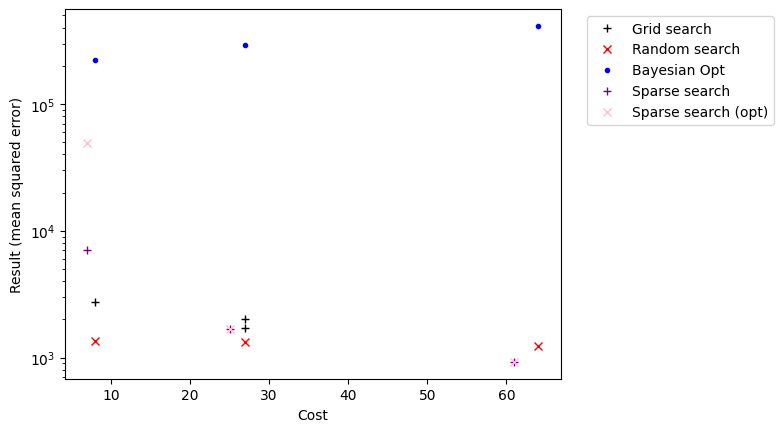

Current dataset: 1 with name id: 359952


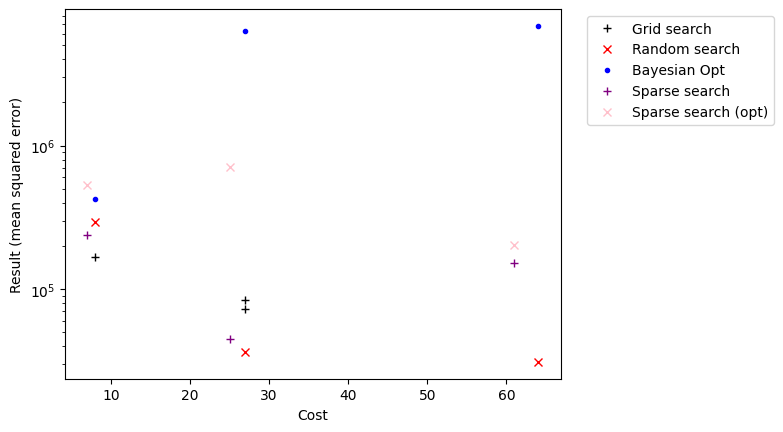

Current dataset: 2 with name id: 359931


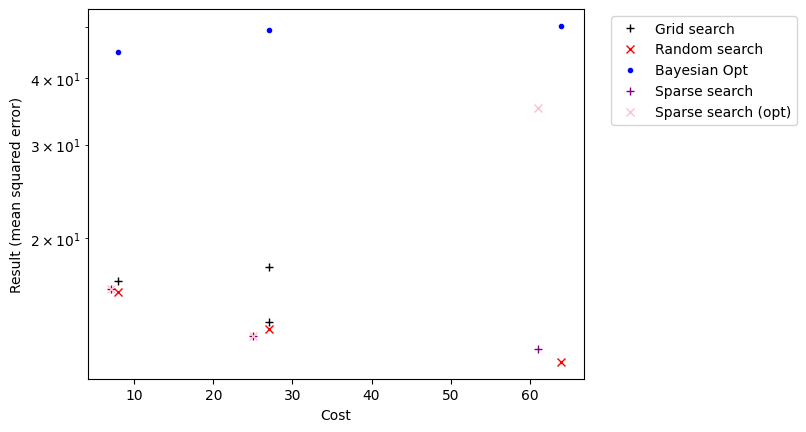

In [26]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

